# Calibrating the Liquid Drop Model Challenge

The purpose of this challenge is for you to calibrate the Liquid Drop Model https://en.wikipedia.org/wiki/Semi-empirical_mass_formula.

If you have never done anything with Python, we suggest you take a look at this: https://www.youtube.com/watch?v=AJFen_Z3mWM&t=1524s. Also, ChatGPT can be of much help to start learning how to code well: https://chatgpt.com/

Your task are to:

*Non-Bayesian way:
- Import the data from the AME 2016 table (included in the github). We are only using nuclei above A=16 to avoid light nuclei where the LDM fails particularly. Perform a curve fit using the built in functions from python (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) and take note of the reported uncertainties in the parameters. 

- Construct a cost function as the sum of the squares of the residuals between your model predictions and the experimental data.

- Numerically minimize this cost function as a function of the four Liquid Drop Model parameters (search on google for scipy minimize function). The optimal parameters will come out of the minimization. 

- Make a plot of the residual of your calibrated model and the experimental data. Notice anything interesting pattern? 



*Bayesian way:
- Make a model calibration using the Bayesian formalism that is defined in the acompaning file "# Guided Example Bayesian calibration". For the error, use your estimation from the previous point (the model error in this case is much smaller than the actual experimental uncertainties). 

- Plot the corner plot posterior as well as the model values on the Binding Energy per nucleon for the Calcium chain up to 60Ca including the available experimental data.

- What would be the results if you have used in the calibration the Binding Energy per nucleon instead of the total Binding Energy?

- Bonus: Find the experimental error in the masses and repeat the calibration using only experimental errors. This should give a good demonstration on the dangers of not taking into account model errors. 


In [46]:
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt

ldm: 29 | n: 29
True


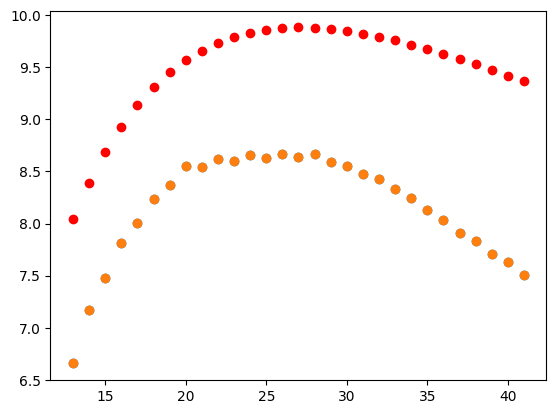

In [47]:
data = np.loadtxt("CorrectedMasses.txt", skiprows=1)
magic_nums = [2, 8, 20, 28, 50, 82, 126]


# x is the constant parameter
operations = [
    lambda x, n, z: x * (n + z),
    lambda x, n, z: -x * (n + z) ** (2 / 3),
    lambda x, n, z: -x * ((n - z) ** 2 / (n + z)),
    lambda x, n, z: -x * ((z**2) / ((n + z) ** (1 / 3))),
    lambda x, n, z: x * (n % 2),
    lambda x, n, z: x * (z % 2),
]

for num in magic_nums:
    operations.append(lambda x, n, z: -x * (1 / (abs(num - n) + 0.25)))
    operations.append(lambda x, n, z: -x * (1 / (abs(num - z) + 0.25)))


def LDM(params, x):
    n, z = x
    output = 0
    for i in range(len(operations)):
        function = operations[i]
        output += function(params[i], n, z)
    return output


calcium_data = data[data[:, 1] == 20]
n = calcium_data[:, 0]  # .flatten()
z = calcium_data[:, 1]  # .flatten()
be = calcium_data[:, 2]

plt.scatter(n, be, label="Exp")
# y_data = data[:, 2].flatten()

# popt, pcov = curve_fit(LDM, (n, z), ydata=y_data)
parameters_guess = [16, 15, 14, 0.7]
parameters_guess = parameters_guess + ([0] * (len(operations) - len(parameters_guess)))
binding_energy_LDM_calcium = [LDM(parameters_guess, [x, 20]) / (x + 20) for x in n]
print("ldm: {} | n: {}".format(len(binding_energy_LDM_calcium), len(n)))
print(len(binding_energy_LDM_calcium) == len(n))
plt.scatter(n, be, label="Experimental Data")
plt.scatter(n, binding_energy_LDM_calcium, label="LDM", color="red")

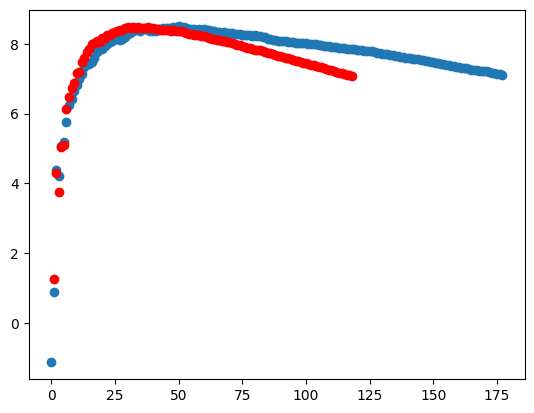

In [48]:
n_or_z = 0
plt_range = range(int(np.max(data[:, n_or_z])) + 1)
avg_be = [np.mean(data[data[:, n_or_z] == i][:, 2])for i in plt_range]
# print(len(avg_be))
# print(data[:, 1])
#plt.scatter
plt.scatter(plt_range, avg_be)

n_or_z = 1
plt_range = range(int(np.max(data[:, n_or_z])) + 1)
avg_be = [np.mean(data[data[:, n_or_z] == i][:, 2])for i in plt_range]
plt.scatter(plt_range, avg_be, color="red")

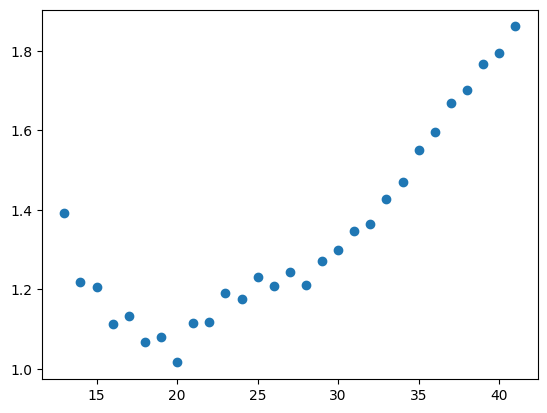

In [49]:
residuals = [binding_energy_LDM_calcium - be]
plt.scatter(n, residuals)

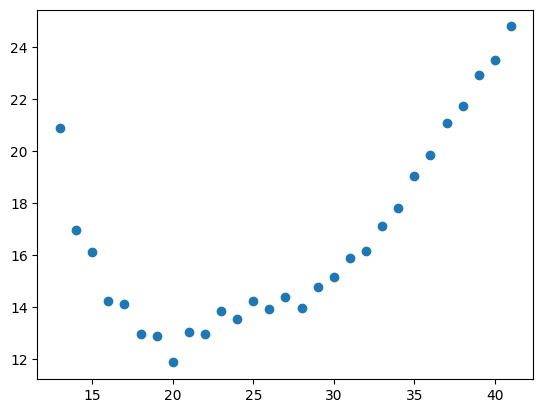

In [50]:
percent_error = [(binding_energy_LDM_calcium - be) / be * 100]
plt.scatter(n, percent_error)

In [51]:
new_data = data[data[:, 1] >= 12]
def cost(paramters):
    binding_energy_residuals = np.array([LDM(paramters, [new_data[i, 0], new_data[i, 1]]) / (new_data[i, 0] + new_data[i, 1]) - new_data[i, 2] for i in range(len(new_data))])
    return np.linalg.norm(binding_energy_residuals)


In [52]:
from scipy.optimize import minimize
result = minimize(cost, parameters_guess)
result.x

array([ 1.46592134e+01,  1.40205030e+01,  2.05670986e+01,  6.34779399e-01,
       -1.57470779e+00, -1.65314666e+00, -6.18201037e-02,  9.68557923e+01,
       -6.18221918e-02,  9.68557934e+01, -6.18227566e-02,  9.68557923e+01,
       -6.18182257e-02,  9.68557914e+01, -6.18209328e-02,  9.68557931e+01,
       -6.18189427e-02,  9.68557922e+01, -6.18241643e-02,  9.68557918e+01])

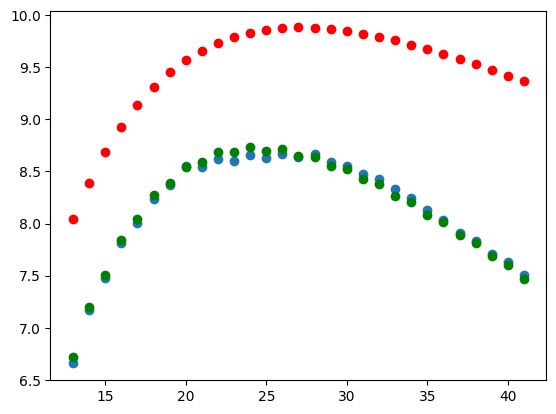

In [53]:
binding_energy_LDM_calcium_calibrated = [LDM(result.x, [x, 20]) / (x + 20) for x in n]
plt.scatter(n, be, label="Experimental Data")
plt.scatter(n, binding_energy_LDM_calcium, color="red", label="Initial Model")
plt.scatter(n, binding_energy_LDM_calcium_calibrated, color="green", label="Calibrated Model")


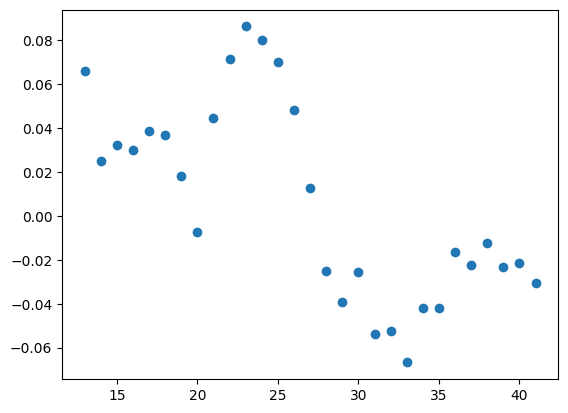

In [54]:
residuals_calibrated = [binding_energy_LDM_calcium_calibrated - be]
plt.scatter(n, residuals_calibrated)